In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.utils.data as Data

In [3]:


data = pd.read_table('zhengqi_train.txt')
data =data[data['V9']>-7.5]
data.drop(['V5','V9','V11','V17','V22','V28'],axis=1)

threshold=0.3
corr_matrix = data.corr().abs()
drop_col=corr_matrix[corr_matrix["target"]<threshold].index
data_ori=data.drop(drop_col.tolist(),axis=1)
data_ori



,V0,V1,V2,V3,V4,V5,V6,V8,V10,V12,V16,V20,V27,V31,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-0.436,-0.940,-0.073,-1.707,0.610,0.168,-0.615,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,0.332,0.188,-0.134,-0.977,0.588,0.338,0.032,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,0.396,0.874,-0.072,-0.618,0.576,0.326,0.277,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,0.403,0.011,-0.014,-0.429,0.272,0.277,0.279,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,0.314,-0.251,0.199,-0.391,0.106,0.332,0.328,-0.280,-0.028,0.384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,0.190,-0.025,-0.138,0.161,0.600,-0.212,0.757,-0.026,0.355,0.436,0.563,0.598,0.189,0.809,0.576,0.686,0.235
2884,0.507,0.557,0.296,0.183,0.530,-0.237,0.749,0.537,-0.061,0.414,0.300,0.562,0.372,0.465,-0.615,-0.380,1.042
2885,-0.394,-0.721,-0.485,0.084,0.136,0.034,0.655,-0.818,0.240,-0.185,0.288,-0.188,0.058,0.268,0.951,0.748,0.005
2886,-0.219,-0.282,-0.344,-0.049,0.449,-0.140,0.560,-0.596,-0.395,-0.053,0.012,-0.497,0.133,-0.051,-0.301,0.555,0.350


In [4]:

# 分割训练集和测试集
x = data_ori.iloc[:, :-1].values
y = data_ori.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 数据标准化
ss = preprocessing.StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)




In [5]:
# numpy转tensor
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().view(-1,1)
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float().view(-1,1)

# batch_size = 64
torch_dataset = Data.TensorDataset(x_train, y_train) 
loader = Data.DataLoader(dataset=torch_dataset, batch_size=64, 
            shuffle=True) 

# print(next(iter(loader)))

In [6]:
class LR(nn.Module):

    def __init__(self):
        super(LR, self).__init__()
        self.fc1 = nn.Linear(16, 48)
        self.fc2 = nn.Linear(48, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [7]:
# 模型初始化
net = LR()
criterion = nn.MSELoss()
optm = torch.optim.Adam(net.parameters(), lr=0.0001, weight_decay=0.01)
epochs = 300


In [8]:
epochs_list=[]
train_loss_list=[]
test_error_list=[]
for e in range(epochs):
    epochs_list.append(e)
    for i, (batch_x, batch_y) in enumerate(loader):
        y_hat = net(batch_x)
#         print(y_hat.shape)
        loss = criterion(y_hat, batch_y)
        optm.zero_grad()
        loss.backward()
        optm.step()
    
    y = net(x_train)
    loss = criterion(y, y_train)
    train_loss_list.append(loss.item())
    y_pred = net(x_test)
    error = criterion(y_pred, y_test)
    test_error_list.append(error.item())
    if (e+1)%50==0:
        print("Epoch:{}, trainLoss:{}，testLoss:{}".format(e+1,loss.item(),error.item()))

Epoch:50, trainLoss:0.12198884785175323，testLoss:0.12387107312679291
Epoch:100, trainLoss:0.11373164504766464，testLoss:0.11632031202316284
Epoch:150, trainLoss:0.10886331647634506，testLoss:0.11271604150533676
Epoch:200, trainLoss:0.10568997263908386，testLoss:0.11028344929218292
Epoch:250, trainLoss:0.10358263552188873，testLoss:0.10964800417423248
Epoch:300, trainLoss:0.10221099108457565，testLoss:0.10894608497619629


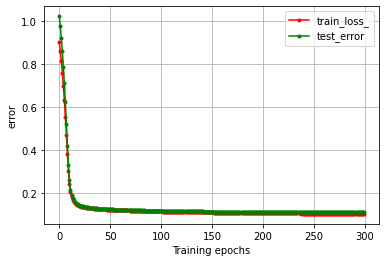

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Training epochs")
plt.ylabel("error")
plt.grid()
plt.plot(epochs_list, train_loss_list, '.-', color="r",
                label="train_loss_")
plt.plot(epochs_list, test_error_list, '.-', color="g",
                label="test_error")

plt.legend(loc="best")